# Orientation Spline: C³ 连续姿态样条

本文档介绍如何使用 `OrientationSpline` 类将离散刀轴姿态拟合为 C³ 连续的弧长参数化样条曲线。

## 1. 为什么用球坐标？

刀轴姿态是单位向量 $\mathbf{O} = (O_i, O_j, O_k)^T$，满足 $\|\mathbf{O}\| = 1$。

如果直接在笛卡尔坐标下拟合 B 样条，插值结果可能不是单位向量。

**解决方案**：转换到球坐标 $(\theta, \phi)$，在球坐标平面拟合 B 样条，再映射回笛卡尔坐标。

$$\mathbf{O} = (\sin\theta\cos\phi, \sin\theta\sin\phi, \cos\theta)^T$$

这样自动保证了 $\|\mathbf{O}\| = 1$。

## 2. 快速上手

In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath("../../.."))

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

from cnc_five_axis_interpolation.core.orientation_spline import OrientationSpline
from cnc_five_axis_interpolation.datasets import ijms2021_fan_shaped_path

%config InlineBackend.figure_format='retina'

In [2]:
# 加载示例数据
positions, orientations, _ = ijms2021_fan_shaped_path()

# 计算弧长
dists = np.linalg.norm(np.diff(positions, axis=0), axis=1)
arc_lengths = np.concatenate([[0], np.cumsum(dists)])

print(f"姿态点数: {len(orientations)}")
print(f"总弧长: {arc_lengths[-1]:.2f} mm")

姿态点数: 25
总弧长: 342.91 mm


In [3]:
# 拟合姿态样条
spline = OrientationSpline(orientations, arc_lengths)
spline.fit()

print(f"姿态样条拟合完成")

姿态样条拟合完成


In [4]:
# 在任意弧长处评估姿态
l = 50.0
ori = spline.evaluate(l)
print(f"l={l}mm 处的姿态: ({ori[0]:.4f}, {ori[1]:.4f}, {ori[2]:.4f})")
print(f"姿态模长: {np.linalg.norm(ori):.10f} (应为 1.0)")

# 批量评估
l_values = np.linspace(0, arc_lengths[-1], 100)
orientations_interp = spline.evaluate_batch(l_values)
print(f"插值点数: {len(orientations_interp)}")

l=50.0mm 处的姿态: (0.1719, 0.6382, 0.7504)
姿态模长: 1.0000000000 (应为 1.0)
插值点数: 100


## 3. 算法原理概述

`OrientationSpline` 的实现分为两个步骤：

### 3.1 球坐标 B 样条拟合 (Eq.25-31)

1. 将姿态向量转换为球坐标 $(\theta, \phi)$：
   $$\theta = \arccos(O_k), \quad \phi = \text{atan2}(O_j, O_i)$$

2. 在 $(\theta, \phi)$ 平面拟合五次 B 样条

3. 评估时映射回笛卡尔坐标

**角度参数化** (Eq.28)：使用相邻姿态间的角度变化分配参数。

> 详细数学推导见 [球坐标姿态理论](/theory/spherical_orientation)

In [5]:
# 验证插值精度
from cnc_five_axis_interpolation.core.orientation_spline import (
    evaluate_orientation_from_spherical,
)

errors = []
for i, w in enumerate(spline.w_bar):
    interp_ori = evaluate_orientation_from_spherical(spline.spline, w)
    interp_ori = interp_ori / np.linalg.norm(interp_ori)
    error = np.linalg.norm(interp_ori - orientations[i])
    errors.append(error)

print(f"插值误差: max={max(errors):.2e}, mean={np.mean(errors):.2e}")

插值误差: max=5.98e-16, mean=2.00e-16


### 3.2 7阶 Bézier 重参数化 (Eq.32-41)

为实现弧长参数化，需要构建映射 $w(l)$，将弧长 $l$ 映射到姿态样条参数 $w$。

**7阶 Bernstein 多项式** (Eq.32-33)：
$$w(r) = \sum_{i=0}^{7} B_{i,7}(r) Q_i$$

**约束条件**：
- C³ 连续性：段间导数连续
- 单调性：$Q_0 \leq Q_1 \leq \cdots \leq Q_7$
- Jerk 最小化：$\min \int |w'''(l)|^2 dl$

> 详细数学推导见 [Bézier重参数化理论](/theory/bezier_reparameterization)

## 4. 可视化

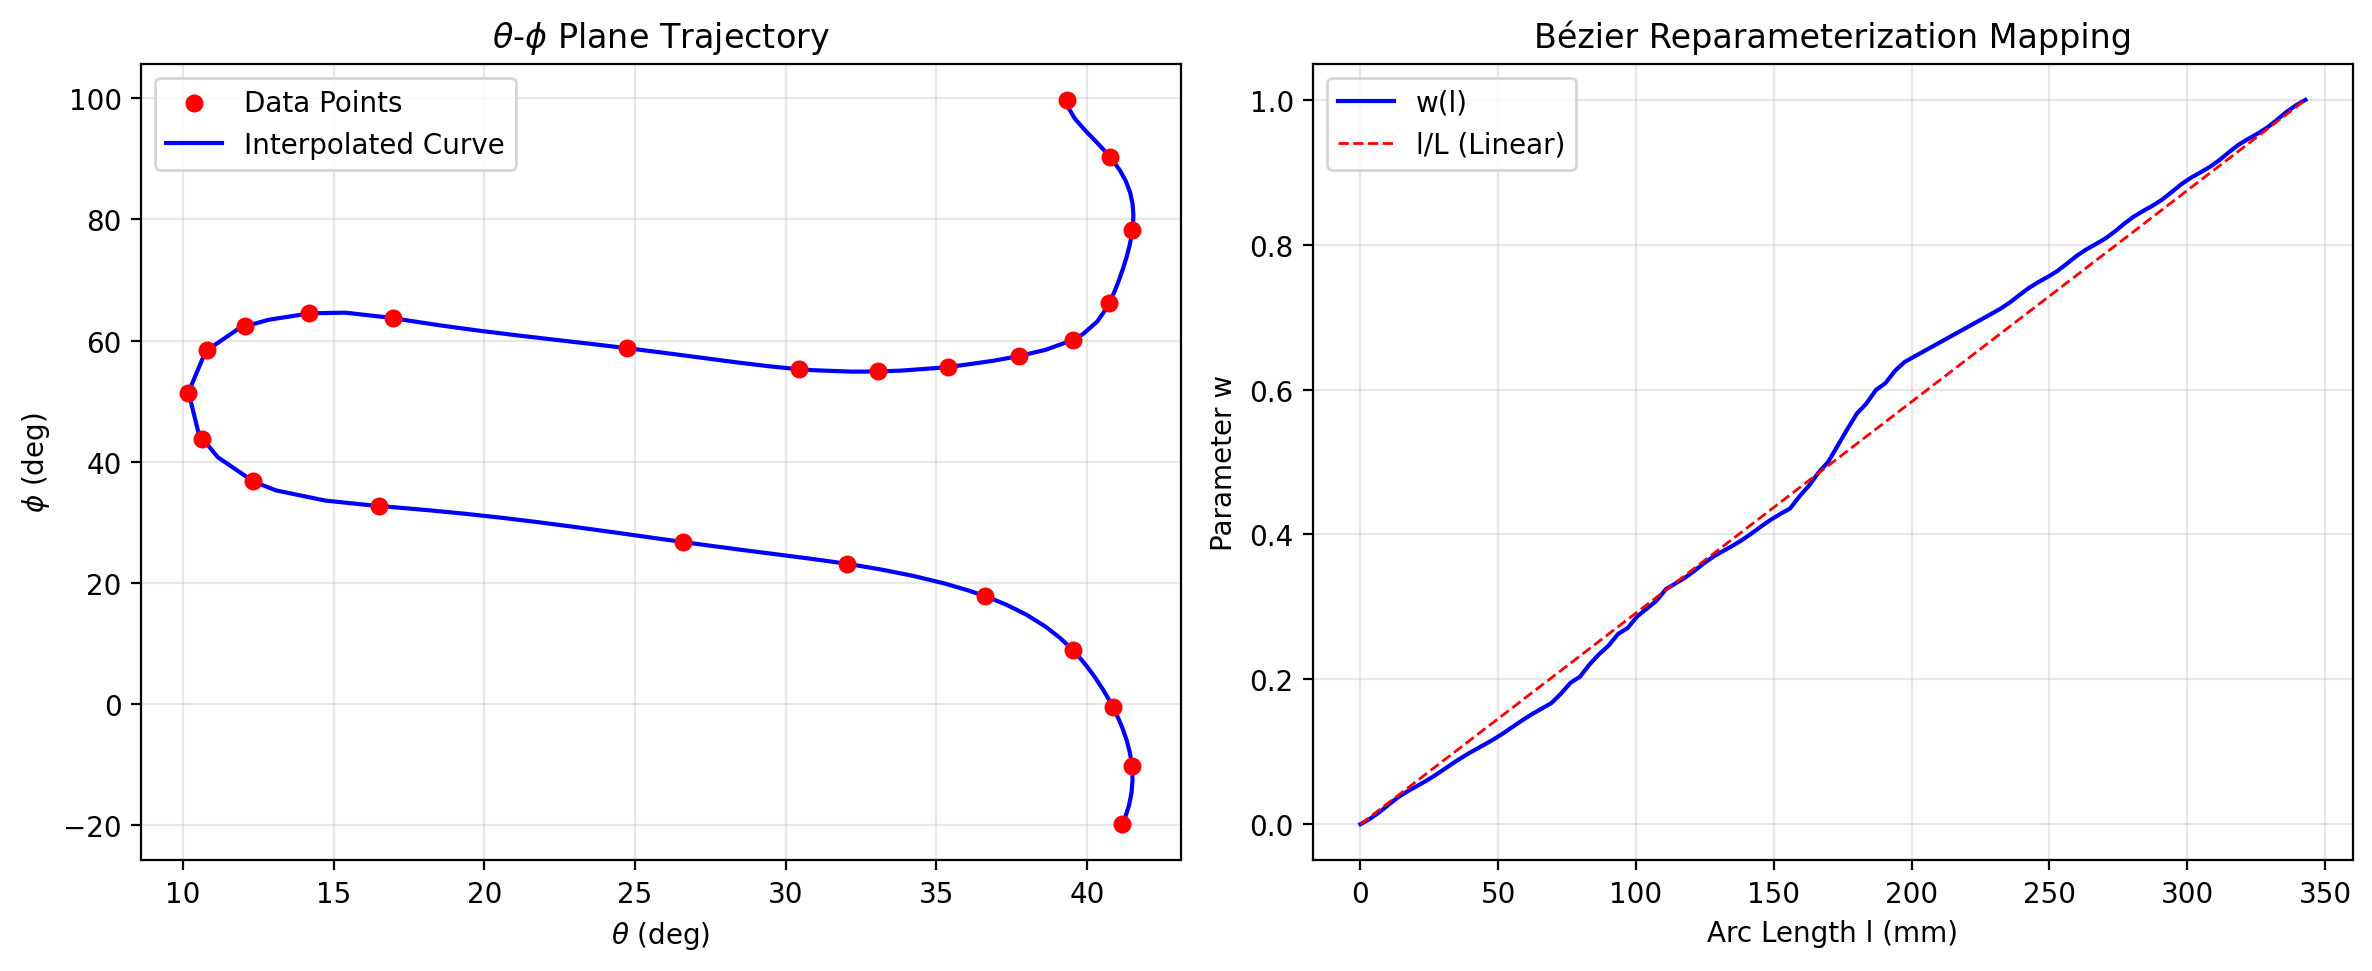

In [6]:
# 球坐标轨迹可视化
from cnc_five_axis_interpolation.utils.geometry import batch_cartesian_to_spherical

# 原始数据点的球坐标
theta_data, phi_data = batch_cartesian_to_spherical(orientations)

# 插值点的球坐标
theta_interp, phi_interp = batch_cartesian_to_spherical(orientations_interp)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 左图：(θ, φ) 平面
axes[0].scatter(
    np.degrees(theta_data),
    np.degrees(phi_data),
    c="red",
    s=30,
    label="Data Points",
    zorder=5,
)
axes[0].plot(
    np.degrees(theta_interp),
    np.degrees(phi_interp),
    "b-",
    linewidth=1.5,
    label="Interpolated Curve",
)
axes[0].set_xlabel(r"$\theta$ (deg)")
axes[0].set_ylabel(r"$\phi$ (deg)")
axes[0].legend()
axes[0].set_title(r"$\theta$-$\phi$ Plane Trajectory")
axes[0].grid(True, alpha=0.3)

# 右图：w(l) 关系
w_values = spline.reparameterization.evaluate_batch(l_values)
axes[1].plot(l_values, w_values, "b-", linewidth=1.5, label="w(l)")
axes[1].plot(
    l_values, l_values / arc_lengths[-1], "r--", linewidth=1, label="l/L (Linear)"
)
axes[1].set_xlabel("Arc Length l (mm)")
axes[1].set_ylabel("Parameter w")
axes[1].legend()
axes[1].set_title("Bézier Reparameterization Mapping")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Plotly 在 MkDocs/nbconvert 下默认输出的是 vnd.plotly JSON，可能导致无法嵌入页面的 warning。
# 解决：显式输出为 HTML（text/html），MkDocs-jupyter 可以直接渲染。

from IPython.display import HTML


def add_unit_sphere(fig, n_lon=24, n_lat=12, line_rgba="black"):
    theta = np.linspace(0, np.pi, 240)
    phi = np.linspace(0, 2 * np.pi, 240)
    for k in range(n_lon):
        p = 2 * np.pi * k / n_lon
        fig.add_trace(
            go.Scatter3d(
                x=np.cos(p) * np.sin(theta),
                y=np.sin(p) * np.sin(theta),
                z=np.cos(theta),
                mode="lines",
                line=dict(color=line_rgba, width=1),
                hoverinfo="skip",
                showlegend=False,
            )
        )
    for k in range(1, n_lat):
        t = np.pi * k / n_lat
        fig.add_trace(
            go.Scatter3d(
                x=np.cos(phi) * np.sin(t),
                y=np.sin(phi) * np.sin(t),
                z=np.full_like(phi, np.cos(t)),
                mode="lines",
                line=dict(color=line_rgba, width=1),
                hoverinfo="skip",
                showlegend=False,
            )
        )


fig = go.Figure()
add_unit_sphere(fig)

fig.add_trace(
    go.Scatter3d(
        x=orientations[:, 0],
        y=orientations[:, 1],
        z=orientations[:, 2],
        mode="markers",
        marker=dict(size=4, color="red"),
        name="Data Points",
    )
)
fig.add_trace(
    go.Scatter3d(
        x=orientations_interp[:, 0],
        y=orientations_interp[:, 1],
        z=orientations_interp[:, 2],
        mode="lines",
        line=dict(width=5, color="blue"),
        name="Interpolated Curve",
    )
)

fig.update_layout(
    title="Orientation Trajectory on Unit Sphere",
    scene=dict(
        xaxis=dict(title="Oi", range=[-1, 1]),
        yaxis=dict(title="Oj", range=[-1, 1]),
        zaxis=dict(title="Ok", range=[-1, 1]),
        aspectmode="cube",
        camera=dict(eye=dict(x=1.15, y=-1.15, z=0.85)),
    ),
    legend=dict(x=0.02, y=0.98),
    margin=dict(l=0, r=0, t=40, b=0),
    height=650,
    width=650,
)

# 关键：输出为 HTML，避免 MkDocs/nbconvert 无法表示 vnd.plotly JSON
HTML(fig.to_html(full_html=False, include_plotlyjs="cdn"))

In [8]:
# 验证姿态始终归一化
norms = np.linalg.norm(orientations_interp, axis=1)
print(f"姿态模长统计: min={norms.min():.10f}, max={norms.max():.10f}")
print(f"✔ 所有姿态均为单位向量: {np.allclose(norms, 1.0)}")

姿态模长统计: min=1.0000000000, max=1.0000000000
✔ 所有姿态均为单位向量: True


## 5. API 参考

### `OrientationSpline` 类

```python
class OrientationSpline:
    def __init__(self, orientations: np.ndarray, arc_lengths: np.ndarray):
        """
        Args:
            orientations: (N, 3) 刀轴姿态向量（单位向量）
            arc_lengths: (N,) 对应的弧长值
        """
    
    def fit(self) -> 'OrientationSpline':
        """拟合样条，返回 self 支持链式调用"""
    
    def evaluate(self, l: float) -> np.ndarray:
        """在弧长 l 处评估姿态，返回 (3,) 单位向量"""
    
    def evaluate_batch(self, l_values: np.ndarray) -> np.ndarray:
        """批量评估，返回 (M, 3) 单位向量数组"""
    
    @property
    def length(self) -> float:
        """轨迹总弧长"""
```

### 属性

| 属性 | 类型 | 说明 |
|------|------|------|
| `spline` | `BSpline` | 球坐标平面的 B 样条 |
| `w_bar` | `ndarray` | 参数化值 |
| `reparameterization` | `BezierReparameterization` | Bézier 重参数化对象 |

## 总结

`OrientationSpline` 通过球坐标转换和 7 阶 Bézier 重参数化，实现了 C³ 连续的弧长参数化姿态样条。球坐标表示自动保证了姿态向量的单位性。